## Homework 5 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 21 March, 2025

In [2]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize

### Problem 1 : Credible and Confidence Intervals
*We are given a dataset with a linear hypothesis.*

---
*a).* We assume a single parameter $y=f(x)=mx$ where $m$ is an unknown slope. We wish to plot the Bayesian posterior PDF assuming a prior that enforces positive $m$ and compare it to one that does not.

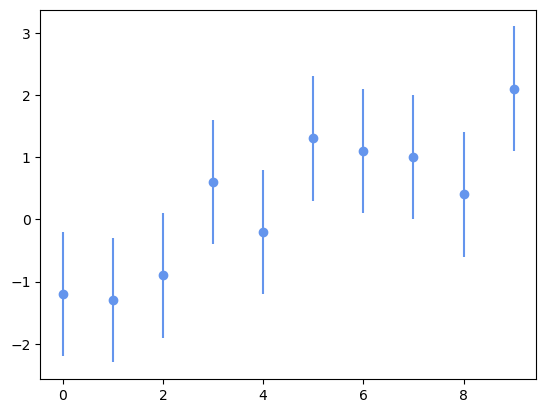

In [3]:
# Import the data and visualize it.
data = np.loadtxt("data_HW5.txt").transpose()
x,y, dy = data
plt.errorbar(x,y,yerr=dy, fmt='o',color='cornflowerblue',label='Dataset 1');

Now for 1a:

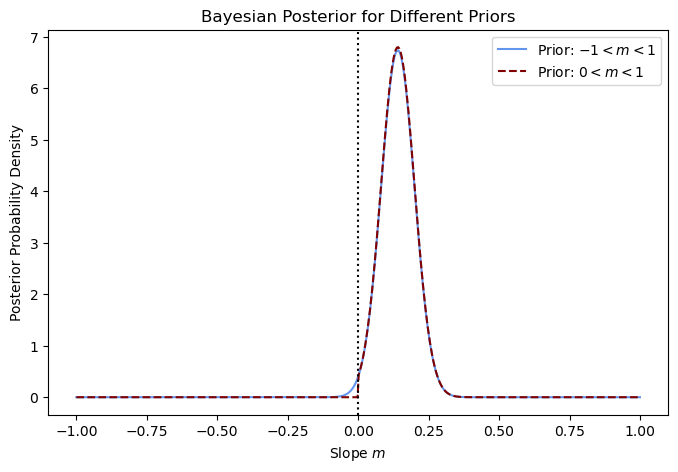

In [41]:
# 1a. Bayesian PDFs 

# Define likelihood function
def log_likelihood(m):
    model = m * x
    return -0.5 * np.sum(((y - model) / dy) ** 2)

# Define priors
def flat_prior(m, prior_type):
    if prior_type == "m > 0":
        return 1.0 if 0 < m < 1 else 0.0
    elif prior_type == "symmetric":
        return 1.0 if -1 < m < 1 else 0.0

# Compute posterior
m_values = np.linspace(-1, 1, 500)
posterior_positive = np.array([np.exp(log_likelihood(m)) * flat_prior(m, "m > 0") for m in m_values])
posterior_symmetric = np.array([np.exp(log_likelihood(m)) * flat_prior(m, "symmetric") for m in m_values])

# Normalize the posterior
posterior_positive /= np.trapezoid(posterior_positive, m_values)
posterior_symmetric /= np.trapezoid(posterior_symmetric, m_values)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(m_values, posterior_symmetric, label=r'Prior: $-1 < m < 1$', color='cornflowerblue')
plt.plot(m_values, posterior_positive, label=r'Prior: $0 < m < 1$', color='maroon', linestyle='dashed')
plt.axvline(0, color='black', linestyle='dotted')
plt.xlabel('Slope $m$')
plt.ylabel('Posterior Probability Density')
plt.legend()
plt.title("Bayesian Posterior for Different Priors")
plt.show()

*b).* We wish to determin the 68% and 90% credible intervals in the case of the non-negative prior. The code is below

68% credible interval: 0.0862 to 0.202
90% credible interval: 0.0501 to 0.238


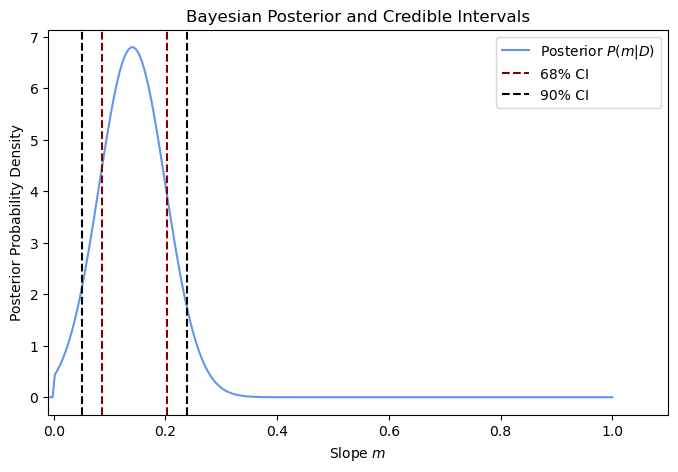

In [40]:
# 1b. Non-negative CDF CIs

# Compute CDF
cdf = cumulative_trapezoid(posterior_positive, m_values, initial=0)
cdf /= cdf[-1]  # Normalize to range [0,1]

# Function to find credible interval
def credible_interval(credibility):
    lower_idx = np.searchsorted(cdf, (1 - credibility) / 2)
    upper_idx = np.searchsorted(cdf, 1 - (1 - credibility) / 2)
    return m_values[lower_idx], m_values[upper_idx]

# Compute 68% and 90% credible intervals
cil_68, ciu_68 = credible_interval(0.68)
cil_90, ciu_90 = credible_interval(0.90)

# Print results
print(f"68% credible interval: {cil_68:0.3g} to {ciu_68:0.3g}")
print(f"90% credible interval: {cil_90:0.3g} to {ciu_90:0.3g}")

# Plot posterior with intervals
plt.figure(figsize=(8, 5))
plt.plot(m_values, posterior_positive, label=r'Posterior $P(m | D)$', color='cornflowerblue')
plt.axvline(cil_68, color='maroon', linestyle='dashed', label="68% CI")
plt.axvline(ciu_68, color='maroon', linestyle='dashed')
plt.axvline(cil_90, color='k', linestyle='dashed', label="90% CI")
plt.axvline(ciu_90, color='k', linestyle='dashed')
plt.xlabel('Slope $m$')
plt.ylabel('Posterior Probability Density')
plt.title("Bayesian Posterior and Credible Intervals")
plt.legend()
plt.xlim(-0.01,)
plt.show()


*c).* Instead, now we wish to compute the credible intervals with the posterior PDFs. The code is below.

In [6]:
# 1c. Credible Intervals from posterior PDFs

def upper_limit(posterior, m_values, credibility):
    cdf = np.cumsum(posterior) / np.sum(posterior)
    upper_idx = np.searchsorted(cdf, credibility)
    return m_values[upper_idx]

# Compute upper limits
ul_68 = upper_limit(posterior_positive, m_values, 0.68)
ul_90 = upper_limit(posterior_positive, m_values, 0.90)

print(f"68% upper limit: {ul_68}")
print(f"90% upper limit: {ul_90}")

68% upper limit: 0.1703406813627253
90% upper limit: 0.21843687374749488


The upper limits are both less than the upper bounds found in part b.

---

*d).* Now, we put on our frequentist hat. We wish to plot the $\chi^2$ as a function of $m$ and find the minimimum. We wish to find the $\Delta \chi^2$ between the best-fit case and the case of $m=0$.

Best-fit slope: 0.1407017485404561
Delta chi^2 between best-fit and m = 0: 5.642140350877184


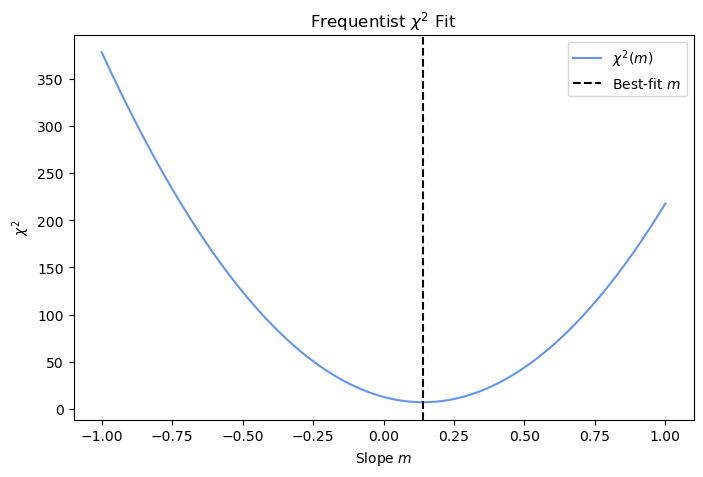

In [7]:
# 1d. Frequentist Appraoch

# Define chi^2 function
def chi2(m):
    model = m * x
    return np.sum(((y - model) / dy) ** 2)

# Compute chi^2 for different m values
chi2_values = np.array([chi2(m) for m in m_values])

# Find best-fit m
result = minimize(chi2, x0=0.5, bounds=[(0, 1)])  # Start at m=0.5, enforce non-negative constraint
m_best = result.x[0]
chi2_min = result.fun

# Compute delta chi^2
delta_chi2 = chi2(0) - chi2_min

print(f"Best-fit slope: {m_best}")
print(f"Delta chi^2 between best-fit and m = 0: {delta_chi2}")

# Plot chi^2 curve
plt.figure(figsize=(8, 5))
plt.plot(m_values, chi2_values, color='cornflowerblue')
plt.axvline(m_best, color='k', linestyle='dashed')
label = [r'$\chi^2(m)$',r'Best-fit $m$'];
plt.xlabel('Slope $m$')
plt.ylabel(r'$\chi^2$');
plt.legend(label)
plt.title(r"Frequentist $\chi^2$ Fit");
plt.show()

*e).* Lastly, we wish to determine the 68% and 90% upper bounds by using the Feldman-Cousins technique. We create pseudo experiments with $m=0$, each with 10 points and Gaussian uncertainty $\sigma_y =1.0$. In each one, we wish to find te best-fit slope and the $\Delta \chi^2$ between best-fit and the case of $m=0$. We wish to find the $\Delta \chi^2$ corresponding to 68% and 90% CIs. We also wish to find the confidence of exclusion of $m=0$.

Critical Delta chi^2 for 68%: 6.922598249248838
Critical Delta chi^2 for 90%: 18.85081849749101


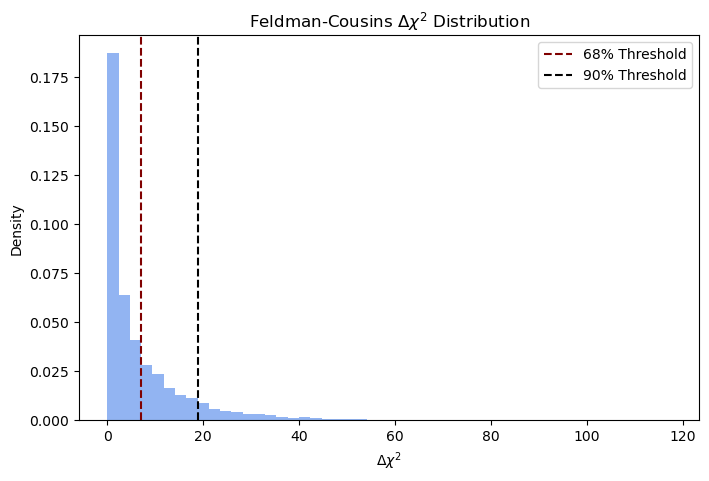

In [37]:
# 1d. Feldman-Cousins

# Running the pseudo-experiments
n_experiments = 10000
dy = 1.0 # The gaussian distributed error
x_fixed = np.linspace(0, 10, 10)  # Simulated x values

best_fit_slopes = []
delta_chi2_values = []

# Run pseudo-experiments
for _ in range(n_experiments):
    y_sim = np.random.normal(0, dy)  # Generate pseudo-data for m=0
    def chi2_sim(m): return np.sum(((y_sim - m * x_fixed) / dy) ** 2)
    
    # Best-fit slope
    result = minimize(chi2_sim, x0=0)
    m_fit = result.x[0]
    best_fit_slopes.append(m_fit)
    
    # Compute delta chi2
    delta_chi2_values.append(chi2_sim(0) - chi2_sim(m_fit))

# Find the critical delta chi2 thresholds
delta_chi2_68 = np.percentile(delta_chi2_values, 68)
delta_chi2_90 = np.percentile(delta_chi2_values, 90)

print(f"Critical Delta chi^2 for 68%: {delta_chi2_68}");
print(f"Critical Delta chi^2 for 90%: {delta_chi2_90}");

# Histogram of delta chi^2 values
plt.figure(figsize=(8, 5))
plt.hist(delta_chi2_values, bins=50, density=True, alpha=0.7, color='cornflowerblue')
plt.axvline(delta_chi2_68, color='maroon', linestyle='dashed', label="68% Threshold")
plt.axvline(delta_chi2_90, color='k', linestyle='dashed', label="90% Threshold")
plt.xlabel(r'$\Delta \chi^2$')
plt.ylabel('Density')
plt.title(r"Feldman-Cousins $\Delta \chi^2$ Distribution")
plt.legend()
plt.show()

Now, we find the confidence of exclusion for $m=0$.

In [ ]:
# Compute delta chi^2 from the actual data
chi2_real = lambda m: np.sum(((y - m * x) / dy) ** 2)
result_real = minimize(chi2_real, x0=0, bounds=[(0, 1)])
m_best_real = result_real.x[0]
delta_chi2_obs = chi2_real(0) - chi2_real(m_best_real)

# Compute confidence level
confidence = np.mean(np.array(delta_chi2_values) < delta_chi2_obs)

print(f"Observed Delta chi^2 : {delta_chi2_obs}")
print(f"Confidence level for excluding m=0: {confidence:.3f} ({confidence * 100:.1f}%)")

Observed Delta chi^2 : 5.642140350877191
Confidence level for excluding m=0: 0.630 (63.0%)
